In [1]:
"""!pip install wandb -q
!pip install tensorflow-gpu"""

'!pip install wandb -q\n!pip install tensorflow-gpu'

In [2]:
"""import torch
import tensorflow as tf
print(tf.__version__)"""
"""
import wandb
from wandb.keras import WandbCallback"""

'\nimport wandb\nfrom wandb.keras import WandbCallback'

In [1]:
!git clone https://github.com/ayulockin/faceattributes.git

fatal: destination path 'faceattributes' already exists and is not an empty directory.


In [2]:
!ls

checkpoint	     data			Incorrect	  utils.py
checkpoint_new	     df_age_result.csv		models		  vgg16.h5
cifar_pytorch.ipynb  df_race_result.csv		__pycache__
cifar_torch_v2.py    faceattributes		pytorch_grad_cam
DAI_ass1_SVM.ipynb   Grad-Cam-checkpoint.ipynb	qu2.ipynb


In [3]:
%cd faceattributes

/DATA/roy2/DAI/faceattributes


In [4]:
!ls

 datasets
'EDA of Face Dataset.ipynb'
 examples
 face_detector
 Image1.jpeg
 images
 LICENSE
 main.py
 prepareUTKFaceData.py
 README.md
'UTK_Face_Attribute_Classifier_with_TF2_0_and_W&B.ipynb'


In [5]:
import os

images = os.listdir('images')
print('Total number of images: ', len(images))

Total number of images:  23705


In [6]:
#!pip3 install scikit-image

In [7]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import warnings
import sys
import os
import shutil
from joblib import dump, load
import numpy as np
import math
import torch

In [8]:
#!pip install tensorflow

In [9]:
labels = pd.read_csv('datasets/face_dataset.csv')

In [10]:
labels['ethnicity'].unique()

array([0, 2, 1, 3, 4])

In [19]:
labels.head(10)

,image_id,age,gender,ethnicity
0,teripprmot,100,0,0
1,ibjkghymsu,100,0,0
2,dlsaxmcymo,100,1,0
3,oyyopnhvza,100,1,0
4,nhufelmwaw,100,1,0
5,fkozflztvo,100,1,0
6,jfjtfckikm,100,1,0
7,exeinekyai,100,1,0
8,ynybxuwyrx,100,1,2
9,pkwnjssqij,100,1,2


In [22]:
labels['ethnicity'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [23]:
labels['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [14]:
labels = labels.sample(frac=1).reset_index(drop=True)

In [15]:
def groupAge(age):
#   Age (0-28 ) as children(28-56) as Young , (56-84) as Adults and (84-116) as Old.
    if age>=0 and age<28:
        return '0 - 28'
    elif age>=28 and age<56:
        return '28 - 56'
    elif age>=56 and age<84:
        return '56 - 24'
    elif age>=84 and age<=116:
        return '84 - 116'

In [16]:
 #White, Black, Asian, Indian, and Others
 def groupRace(race):
    if race == 0:
        return 'White'
    elif race == 1:
        return 'Black'
    elif race == 2:
        return 'Asian'
    elif race == 3:
        return 'Indian'
    else:
        return 'Other'


In [17]:
import numpy as np 
import cv2
import random
import matplotlib.pyplot as plt

%matplotlib inline

#from tensorflow.keras.utils import to_categorical

In [18]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [19]:
def formatdata(train_count, validation_count, test_count):
  partitions = {'train': [],
                'validation': [],
                'test': []}
  labels_dict = {'train_age': [], 'train_gender': [], 'train_ethnicity': [],
                 'validation_age': [], 'validation_gender': [], 'validation_ethnicity': [],
                 'test_age': [], 'test_gender': [], 'test_ethnicity': []}
  random.seed(1)

  print("[INFO] Preparing train data....")
  for ID in range(train_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['train_age'].append(groupAge(data[0][1]))
        labels_dict['train_gender'].append(data[0][2])
        labels_dict['train_ethnicity'].append(groupRace(data[0][3]))
        partitions['train'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  print("[INFO] Preparing validation data....")
  for ID in range(train_count, train_count+validation_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['validation_age'].append(groupAge(data[0][1]))
        labels_dict['validation_gender'].append(data[0][2])
        labels_dict['validation_ethnicity'].append(groupRace(data[0][3]))
        partitions['validation'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  ## Uncomment to get test split
  print("[INFO] Preparing test data....")
  for ID in range(train_count+validation_count,train_count+validation_count+test_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['test_age'].append(groupAge(data[0][1]))
        labels_dict['test_gender'].append(data[0][2])
        labels_dict['test_ethnicity'].append(groupRace(data[0][3]))
        partitions['test'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  return partitions, labels_dict

In [20]:
# train:validation:test = 70:20:10 = 16596:4742:2370

train_count = 16595
validation_count = 4741
test_count = 2369

partitions, labels_dict = formatdata(train_count, validation_count, test_count)

[INFO] Preparing train data....
[INFO] Done
[INFO] Preparing validation data....
[INFO] Done
[INFO] Preparing test data....
[INFO] Done


In [21]:
print("[INFO] Training Data")
print("Size of train data: ", len(partitions['train']))
print("Size of age as label: ", len(labels_dict['train_age']))
print("Size of gender as label: ", len(labels_dict['train_gender']))
print("Size of ethnicity as label: ", len(labels_dict['train_ethnicity']))
print("\n")
print("[INFO] Validation Data")
print("Size of validation data: ", len(partitions['validation']))
print("Size of age as label: ", len(labels_dict['validation_age']))
print("Size of gender as label: ", len(labels_dict['validation_gender']))
print("Size of ethnicity as label: ", len(labels_dict['validation_ethnicity']))
print("\n")
# Uncomment to log test split details
print("[INFO] Test Data")
print("Size of test data: ", len(partitions['test']))
print("Size of age as label: ", len(labels_dict['test_age']))
print("Size of gender as label: ", len(labels_dict['test_gender']))
print("Size of ethnicity as label: ", len(labels_dict['test_ethnicity']))

[INFO] Training Data
Size of train data:  16595
Size of age as label:  16595
Size of gender as label:  16595
Size of ethnicity as label:  16595


[INFO] Validation Data
Size of validation data:  4741
Size of age as label:  4741
Size of gender as label:  4741
Size of ethnicity as label:  4741


[INFO] Test Data
Size of test data:  2369
Size of age as label:  2369
Size of gender as label:  2369
Size of ethnicity as label:  2369


In [22]:
import imageio

In [27]:
def loadImages(images, imagesPath):
    print("[INFO] Loading....")
    X = []
    count = 0
    for image in images:
        if count%1000==0:
            print("[INFO] {} images loaded".format(count))
        img = imageio.imread(imagesPath+'/'+image)
        img = np.array(img)
        #resized_images = rescale(img, 0.5, anti_aliasing=False)
        resized_images = cv2.resize(img,(32,32))
        X.append(resized_images)
        count+=1
    print("[INFO] Done")
    return np.array(X)

In [28]:
print("[INFO] Training Data")
trainX = loadImages(partitions['train'], 'images/')
print("[INFO] Validation Data")
validationX = loadImages(partitions['validation'], 'images/')

[INFO] Training Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] 3000 images loaded
[INFO] 4000 images loaded
[INFO] 5000 images loaded
[INFO] 6000 images loaded
[INFO] 7000 images loaded
[INFO] 8000 images loaded
[INFO] 9000 images loaded
[INFO] 10000 images loaded
[INFO] 11000 images loaded
[INFO] 12000 images loaded
[INFO] 13000 images loaded
[INFO] 14000 images loaded
[INFO] 15000 images loaded
[INFO] 16000 images loaded
[INFO] Done
[INFO] Validation Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] 3000 images loaded
[INFO] 4000 images loaded
[INFO] Done


In [29]:
print("[INFO] test Data")
testX = loadImages(partitions['test'], 'images/')
testX = testX/255.0
testX_reshape = testX.flatten().reshape(testX.shape[0],testX.shape[1]* testX.shape[2]* testX.shape[3])

[INFO] test Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] Done


In [30]:
trainX = trainX/255.0
validationX = validationX/255.0

In [31]:
print("[INFO] Training Images: ", trainX.shape)
print("[INFO] Validation Images: ", validationX.shape)
trainX_reshape = trainX.flatten().reshape(trainX.shape[0],trainX.shape[1]* trainX.shape[2]* trainX.shape[3] )
validationX_reshape = validationX.flatten().reshape(validationX.shape[0],validationX.shape[1]* validationX.shape[2]* validationX.shape[3])

[INFO] Training Images:  (16595, 32, 32, 3)
[INFO] Validation Images:  (4741, 32, 32, 3)


In [32]:
print(trainX_reshape.shape, validationX_reshape.shape)


(16595, 3072) (4741, 3072)


In [33]:
trainY = {
    'gender': np.array(labels_dict['train_gender']),
    'ethnicity': np.array(labels_dict['train_ethnicity']),
    'age': np.array(labels_dict['train_age'])
}

validationY = {
    'gender': np.array(labels_dict['validation_gender']),
    'ethnicity': np.array(labels_dict['validation_ethnicity']),
    'age': np.array(labels_dict['validation_age'])
}
testY = {
    'gender': np.array(labels_dict['test_gender']),
    'ethnicity': np.array(labels_dict['test_ethnicity']),
    'age': np.array(labels_dict['test_age'])
}

trainY['gender'] = trainY['gender'].reshape(trainY['gender'].shape[0], 1)
validationY['gender'] = validationY['gender'].reshape(validationY['gender'].shape[0], 1)
sample_test = testY['gender']
testY['gender'] = testY['gender'].reshape(testY['gender'].shape[0], 1)

In [34]:
print(testY['age'])

['0 - 28' '28 - 56' '0 - 28' ... '28 - 56' '0 - 28' '0 - 28']


In [35]:
print('Training labels')
print('[INFO] Shape of gender label: ', trainY['gender'].shape)
print('[INFO] Shape of ethnicity label: ', trainY['ethnicity'].shape)
print('[INFO] Shape of age label: ', trainY['age'].shape)
print('\nValidation labels')
print('[INFO] Shape of gender label: ', validationY['gender'].shape)
print('[INFO] Shape of ethnicity label: ', validationY['ethnicity'].shape)
print('[INFO] Shape of age label: ', validationY['age'].shape)

Training labels
[INFO] Shape of gender label:  (16595, 1)
[INFO] Shape of ethnicity label:  (16595,)
[INFO] Shape of age label:  (16595,)

Validation labels
[INFO] Shape of gender label:  (4741, 1)
[INFO] Shape of ethnicity label:  (4741,)
[INFO] Shape of age label:  (4741,)


In [36]:
"""def validate(X_val, y_val, i):
    predicted = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, predicted)
    print(accuracy, i)
    if accuracy < 0.11:
        pass
        print("Skipping for gamma {}". format(i))
    candidate = {
        'acc_valid' : accuracy,
        'gamma' : i,
        }
    return candidate"""

'def validate(X_val, y_val, i):\n    predicted = clf.predict(X_val)\n    accuracy = metrics.accuracy_score(y_val, predicted)\n    print(accuracy, i)\n    if accuracy < 0.11:\n        pass\n        print("Skipping for gamma {}". format(i))\n    candidate = {\n        \'acc_valid\' : accuracy,\n        \'gamma\' : i,\n        }\n    return candidate'

In [37]:
"""mydir = "/DATA/roy2/DAI/models"
if os.path.exists(mydir):
    shutil.rmtree(mydir)"""


'mydir = "/DATA/roy2/DAI/models"\nif os.path.exists(mydir):\n    shutil.rmtree(mydir)'

In [38]:
"""parames = [1e-7,1e-5,1e-3,0.01,0.1,1]
model_candidate = []
for i in parames:
  clf = svm.SVC(kernel = 'linear', gamma=i)
  clf.fit(trainX_reshape, trainY['gender'])
  model_candidate.append(validate(validationX_reshape, validationY['gender'],i))
  mydir = "/DATA/roy2/DAI/models/" 
  output = mydir+"gamma_{}".format(i)
  os.makedirs(output)
  dump(clf, os.path.join(output,"model.joblib"))"""


'parames = [1e-7,1e-5,1e-3,0.01,0.1,1]\nmodel_candidate = []\nfor i in parames:\n  clf = svm.SVC(kernel = \'linear\', gamma=i)\n  clf.fit(trainX_reshape, trainY[\'gender\'])\n  model_candidate.append(validate(validationX_reshape, validationY[\'gender\'],i))\n  mydir = "/DATA/roy2/DAI/models/" \n  output = mydir+"gamma_{}".format(i)\n  os.makedirs(output)\n  dump(clf, os.path.join(output,"model.joblib"))'

In [39]:
"""def report(clf, y_test, predicted):
    print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

def test(X_test, y_test,best_model_folder):
    clf = load(os.path.join(best_model_folder,"model.joblib"))
    predicted = clf.predict(X_test)
    report(clf, y_test, predicted)
    return clf, predicted # classification report function"""

'def report(clf, y_test, predicted):\n    print(f"Classification report for classifier {clf}:\n"\n      f"{metrics.classification_report(y_test, predicted)}\n")\n\ndef test(X_test, y_test,best_model_folder):\n    clf = load(os.path.join(best_model_folder,"model.joblib"))\n    predicted = clf.predict(X_test)\n    report(clf, y_test, predicted)\n    return clf, predicted # classification report function'

In [40]:
# clf = SVC().fit(trainX_reshape, trainY['gender'])

In [41]:
#max_valid = max(model_candidate, key = lambda x: x['acc_valid']) # extract the model based on max accuracy
"""
best_model_folder = "/DATA/roy2/DAI/models/gamma_{}".format(0.01)

clf, predicted = test(testX_reshape, testY['gender'],best_model_folder)""" # test function

'\nbest_model_folder = "/DATA/roy2/DAI/models/gamma_{}".format(0.01)\n\nclf, predicted = test(testX_reshape, testY[\'gender\'],best_model_folder)'

In [42]:
# print(accuracy)
#model_candidate

In [43]:
# for  gamma = 'auto'
from sklearn.externals import joblib

clf = svm.SVC(kernel = 'linear', gamma='auto', probability = True)
clf.fit(trainX_reshape, trainY['gender'])
joblib.dump(clf,'/DATA/roy2/DAI/models/clf.pkl')

/DATA/roy2/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/DATA/roy2/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['/DATA/roy2/DAI/models/clf.pkl']

In [44]:
y_prob = clf.predict_proba(testX_reshape)
y_pred = clf.predict(testX_reshape)
accuracy = clf.score(testX_reshape, testY['gender'])
cm = confusion_matrix(testY['gender'], y_pred)

In [45]:
accuracy

0.8547910510764035

In [46]:
pd.DataFrame(cm, index = ['female', 'male'], columns = ['female','male' ])

,female,male
female,1076,183
male,161,949


# Creating Dataframe for class-wise accuracy

In [47]:
df_test = pd.DataFrame()
df_test['gender'] = sample_test
df_test['age'] = testY['age']
df_test['ethnicity'] = testY['ethnicity']
df_test['predicted'] = y_pred
#df_test['input'] = testX

In [48]:
df_test

,gender,age,ethnicity,predicted
0,0,0 - 28,Black,0
1,0,28 - 56,Black,1
2,1,0 - 28,Black,0
3,0,28 - 56,White,0
4,1,0 - 28,Indian,1
...,...,...,...,...
2364,1,0 - 28,Indian,1
2365,0,0 - 28,Asian,0
2366,0,28 - 56,Black,0
2367,1,0 - 28,White,1


In [49]:
l = df_test['age'].unique()
gk = df_test.groupby('age')


In [50]:
acc = []
group_age = []
count = []
for i in range(len(l)):
    df_test_age=gk.get_group(l[i])
    accuracy = accuracy_score(df_test_age['predicted'], df_test_age['gender'])
    cm = confusion_matrix(df_test_age['predicted'], df_test_age['gender'])
    acc.append(accuracy)
    group_age.append(l[i])
    count.append(len(df_test_age))
    print(l[i])
    print(accuracy)
    print(cm)

0 - 28
0.7909604519774012
[[333  87]
 [135 507]]
28 - 56
0.9237713139418254
[[567  44]
 [ 32 354]]
56 - 24
0.8913857677902621
[[164  16]
 [ 13  74]]
84 - 116
0.6046511627906976
[[12 14]
 [ 3 14]]


In [51]:
df_age_result = pd.DataFrame()
df_age_result['age'] = group_age
df_age_result['acc'] = acc
df_age_result['count'] = count
df_age_result

,age,acc,count
0,0 - 28,0.790960,1062
1,28 - 56,0.923771,997
2,56 - 24,0.891386,267
3,84 - 116,0.604651,43


In [52]:
l = df_test['ethnicity'].unique()
#print(l)
gk1 = df_test.groupby('ethnicity')
acc = []
group_race = []
count = []
for i in range(len(l)):
    df_test_race=gk1.get_group(l[i])
    accuracy = accuracy_score(df_test_race['predicted'], df_test_race['gender'])
    cm = confusion_matrix(df_test_race['predicted'], df_test_race['gender'])
    acc.append(accuracy)
    group_race.append(l[i])
    count.append(len(df_test_race))
    print(l[i])
    print(accuracy)
    print(cm)
    df_test_race = pd.DataFrame()

Black
0.8760683760683761
[[217  32]
 [ 26 193]]
White
0.8507772020725388
[[451  67]
 [ 77 370]]
Indian
0.9007263922518159
[[215  23]
 [ 18 157]]
Asian
0.7982456140350878
[[120  27]
 [ 42 153]]
Other
0.8232044198895028
[[73 12]
 [20 76]]


In [53]:
df_race_result = pd.DataFrame()
df_race_result['race'] = group_race
df_race_result['acc'] = acc
df_race_result['count'] = count
df_race_result

,race,acc,count
0,Black,0.876068,468
1,White,0.850777,965
2,Indian,0.900726,413
3,Asian,0.798246,342
4,Other,0.823204,181


In [54]:
df_age_result.to_csv('/DATA/roy2/DAI/df_age_result.csv', index = False)
df_race_result.to_csv('/DATA/roy2/DAI/df_race_result.csv', index = False)

# ROC

In [55]:
def get_values(y_true, y_prob, thresholds):

    fpr = []
    tpr = []
    precision = []
    far = []
    frr = []
    for threshold in thresholds:

        y_pred = np.where(y_prob >= threshold, 1, 0)

        # fp = np.sum((y_pred == 1) & (y_true == 0))
        # tp = np.sum((y_pred == 1) & (y_true == 1))

        # fn = np.sum((y_pred == 0) & (y_true == 1))
        # tn = np.sum((y_pred == 0) & (y_true == 0))
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
        precision.append(tp / (tp + fp))
        far.append(fp / (fp + tn))
        frr.append(fn / (tp + fn))
    return [fpr, tpr, precision, tpr, far, frr]

In [56]:
thresholds = []
i = 0.0001
while i < 1:
  thresholds.append(i)
  i += 0.0001

In [57]:
y_test = sample_test
y_prob = y_prob

In [58]:
fpr1, tpr1, precision1, recall1, far1, frr1 = get_values(y_test, y_prob[:, 1], thresholds)

/DATA/roy2/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


# Precision - recall curve

Text(0, 0.5, 'Precision')

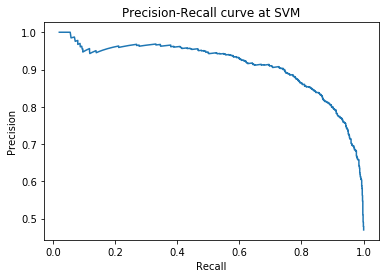

In [60]:
plt.plot(recall1, precision1)
plt.title("Precision-Recall curve at SVM")
plt.xlabel('Recall')
plt.ylabel('Precision')

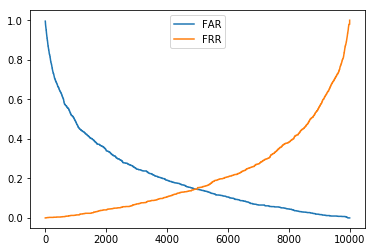

In [61]:
plt.plot(far1)
plt.plot(frr1)
plt.legend(['FAR', 'FRR'])

In [62]:
index = -1
ans = 1000
t = []
for i in range(len(far1)):
  if ans > abs(far1[i]-frr1[i]):
    ans = abs(far1[i]-frr1[i])
    index = i
print(ans, index, far1[index], frr1[index])

0.0003084100780685606 4905 0.1453534551231136 0.14504504504504503


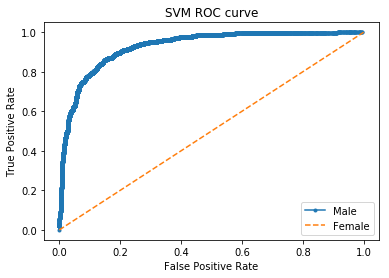

In [64]:
from matplotlib import pyplot as plt
plt.plot(fpr1, tpr1, marker='.', label='Male')
plt.plot([0, 1], [0, 1], linestyle='--', label='Female')
plt.title("SVM ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()